In [ ]:
import os, fiona, glob
import geopandas as gpd
import pandas as pd
from rasterio.crs import CRS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import shapely
import matplotlib.pyplot as plt

In [ ]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.7299, -77.5886, 36.9909, -81.6319] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_tot' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

In [ ]:
# Import all files from wv GDB.  
dir = f'{PATH}/{PROJ_TITLE}/GeoDatabases'
path_list = glob.glob(f'{dir}/*.zip')
master_dip_gdf = gpd.GeoDataFrame()
master_geol_gdf = gpd.GeoDataFrame()
for path in path_list:
    try:
        layers = fiona.listlayers(path)
        for layer in layers:
            if 'bed' in layer.lower():
                dip_gdf = gpd.read_file(path, layer=layer)
                dip_gdf.columns = [x.lower() for x in dip_gdf.columns]
                master_dip_gdf = pd.concat([master_dip_gdf, dip_gdf], ignore_index=True)
            elif 'cnt_poly' in layer.lower():
                geol_gdf = gpd.read_file(path, layer=layer)
                geol_gdf.columns = [x.lower() for x in geol_gdf.columns]
                master_geol_gdf= pd.concat([master_geol_gdf, geol_gdf], ignore_index=True)
    except Exception as e:
        pass

master_dip_gdf = master_dip_gdf[['dip_angle', 'dip_direct', 'geometry']].drop_duplicates(subset = ['geometry'], keep='first').to_crs(CRS.from_epsg(2283))
master_geol_gdf = master_geol_gdf[['unit_abbrv', 'geometry']].to_crs(CRS.from_epsg(2283))

In [ ]:
from pyproj import Proj, transform
import numpy as np

kps_dip_strat = []

ksn_paths = glob.glob(f'{PATH}/{PROJ_TITLE}/lsht_kps/*.csv')
for csv in ksn_paths:
    csv_name = csv.split(sep='/')[-1]
    wshed_name = csv_name[0:-13]
    ksn_df = pd.read_csv(csv, index_col=0)[['x','y','longitude','latitude','wshed','delta_ksn','elevation']]
    kp_df = gpd.GeoDataFrame(data=ksn_df, geometry= gpd.points_from_xy(ksn_df.x, ksn_df.y), crs=CRS.from_epsg(2283))
    kp_dip = gpd.sjoin_nearest(master_dip_gdf, kp_df, max_distance=300, distance_col='dist_from_dip')

    if len(kp_dip) != 0:
        kp_dip = kp_dip.drop(columns=['index_right'])
        kp_strat = gpd.sjoin(left_df=kp_dip, right_df=master_geol_gdf, how='inner')
        kps_dip_strat.append(kp_strat)

In [ ]:
kps_dip_strat_fin = []
for df in kps_dip_strat:
    if len(df) > 10:
        dip_data = df.dip_angle # get dip data
        dip_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90] #bin edges
        dip_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'] #labels
        binned_dips = pd.cut(dip_data, bins=dip_bins, labels=dip_labels, right=True) #binned

        df['dip_bin'] = binned_dips

        elev_data = df.elevation
        binned_elev = pd.cut(elev_data, bins = np.arange(round(elev_data.min()-10, -1), round(elev_data.max()+30, -1), step=20))

        df['elev_bin'] = binned_elev

        kps_dip_strat_fin.append(df)

# Normalizing Practice

In [ ]:
nms=[]
for x in kps_dip_strat_fin:
    nms.append(f"{PATH}/{PROJ_TITLE}/ksn_csvs/{x.iloc[0]['wshed']}_reproj_ksn.csv")
print(nms)

In [ ]:
ksn_gdfs_list = []

for x in nms:
    csv_name = x.split(sep='/')[-1]
    wshed_name = csv_name[0:-15]
    df = pd.read_csv(x)
    gdf = gpd.GeoDataFrame(data=df, geometry=gpd.points_from_xy(df.x, df.y), crs=CRS.from_epsg(2283))
    
    # Join with dip
    ksn_dip = gpd.sjoin_nearest(master_dip_gdf, gdf, max_distance=300, distance_col='dist_from_dip')
    ksn_dip = ksn_dip.drop(columns=['index_right'])
   
    # Join with stratigraphy
    ksn_dip_strat = gpd.sjoin(left_df=ksn_dip, right_df=master_geol_gdf, how='inner')
    
    # Add a column for bins of dip
    dip_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90] #bin edges
    dip_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'] #labels
    binned_dips = pd.cut(ksn_dip_strat.dip_angle, bins=dip_bins, labels=dip_labels, right=True) #binned
    ksn_dip_strat['dip_bin'] = binned_dips

    # Add column for bins of elevation
    elev_data = ksn_dip_strat.elevation
    binned_elev = pd.cut(elev_data, bins = np.arange(round(elev_data.min()-10, -1), round(elev_data.max()+30, -1), step=20))
    ksn_dip_strat['elev_bin'] = binned_elev

    # Add wshed name
    ksn_dip_strat['wshed'] = [wshed_name]*len(ksn_dip_strat)

    # Add to list
    ksn_gdfs_list.append(ksn_dip_strat[['dip_angle','dip_direct','m_chi','segmented_elevation','x','y','dist_from_dip','unit_abbrv','dip_bin','elev_bin','wshed']])

Unit      0-10     11-20     21-30     31-40     41-50     51-60     61-70  \
0   Mps  0.096774  0.133333  0.105263  0.091954       0.0       0.0       0.0   
0   Mpr  0.096774       0.0       0.0       0.0       0.0       0.0       0.0   
0   Dhs       0.0       0.4  0.210526  0.183908  0.222222   0.16092       0.0   
0   Dch       0.0       0.4       0.0  0.091954  0.333333  0.241379  0.129032   
0   Mpk       0.0       0.0       0.0  0.091954       0.0       0.0       0.0   
0   Dbh       0.0  0.133333       0.0       0.0  0.111111   0.08046  0.064516   
0    Sb       0.0       0.0       0.0  0.091954       0.0       0.0       0.0   
0    DS       0.0       0.0       0.0       0.0  0.111111       0.0       0.0   
0    Sk       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
0   Dmt  0.096774       0.0  0.315789  0.183908  0.333333   0.08046       0.0   
0    St       0.0       0.0  0.105263       0.0       0.0       0.0       0.0   
0    Mm       0.0       0.0  0.105263       0.0       0.0       0.0  0.064516   
0  Mmlm       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      71-80     81-90  
0       0.0       0.0  
0       0.0       0.0  
0       0.0       0.0  
0       0.0       0.0  
0       0.0       0.0  
0  0.085714  0.153846  
0       0.0  0.153846  
0  0.085714       0.0  
0  0.085714       0.0  
0       0.0       0.0  
0       0.0       0.0  
0       0.0       0.0  
0       0.0       0.0

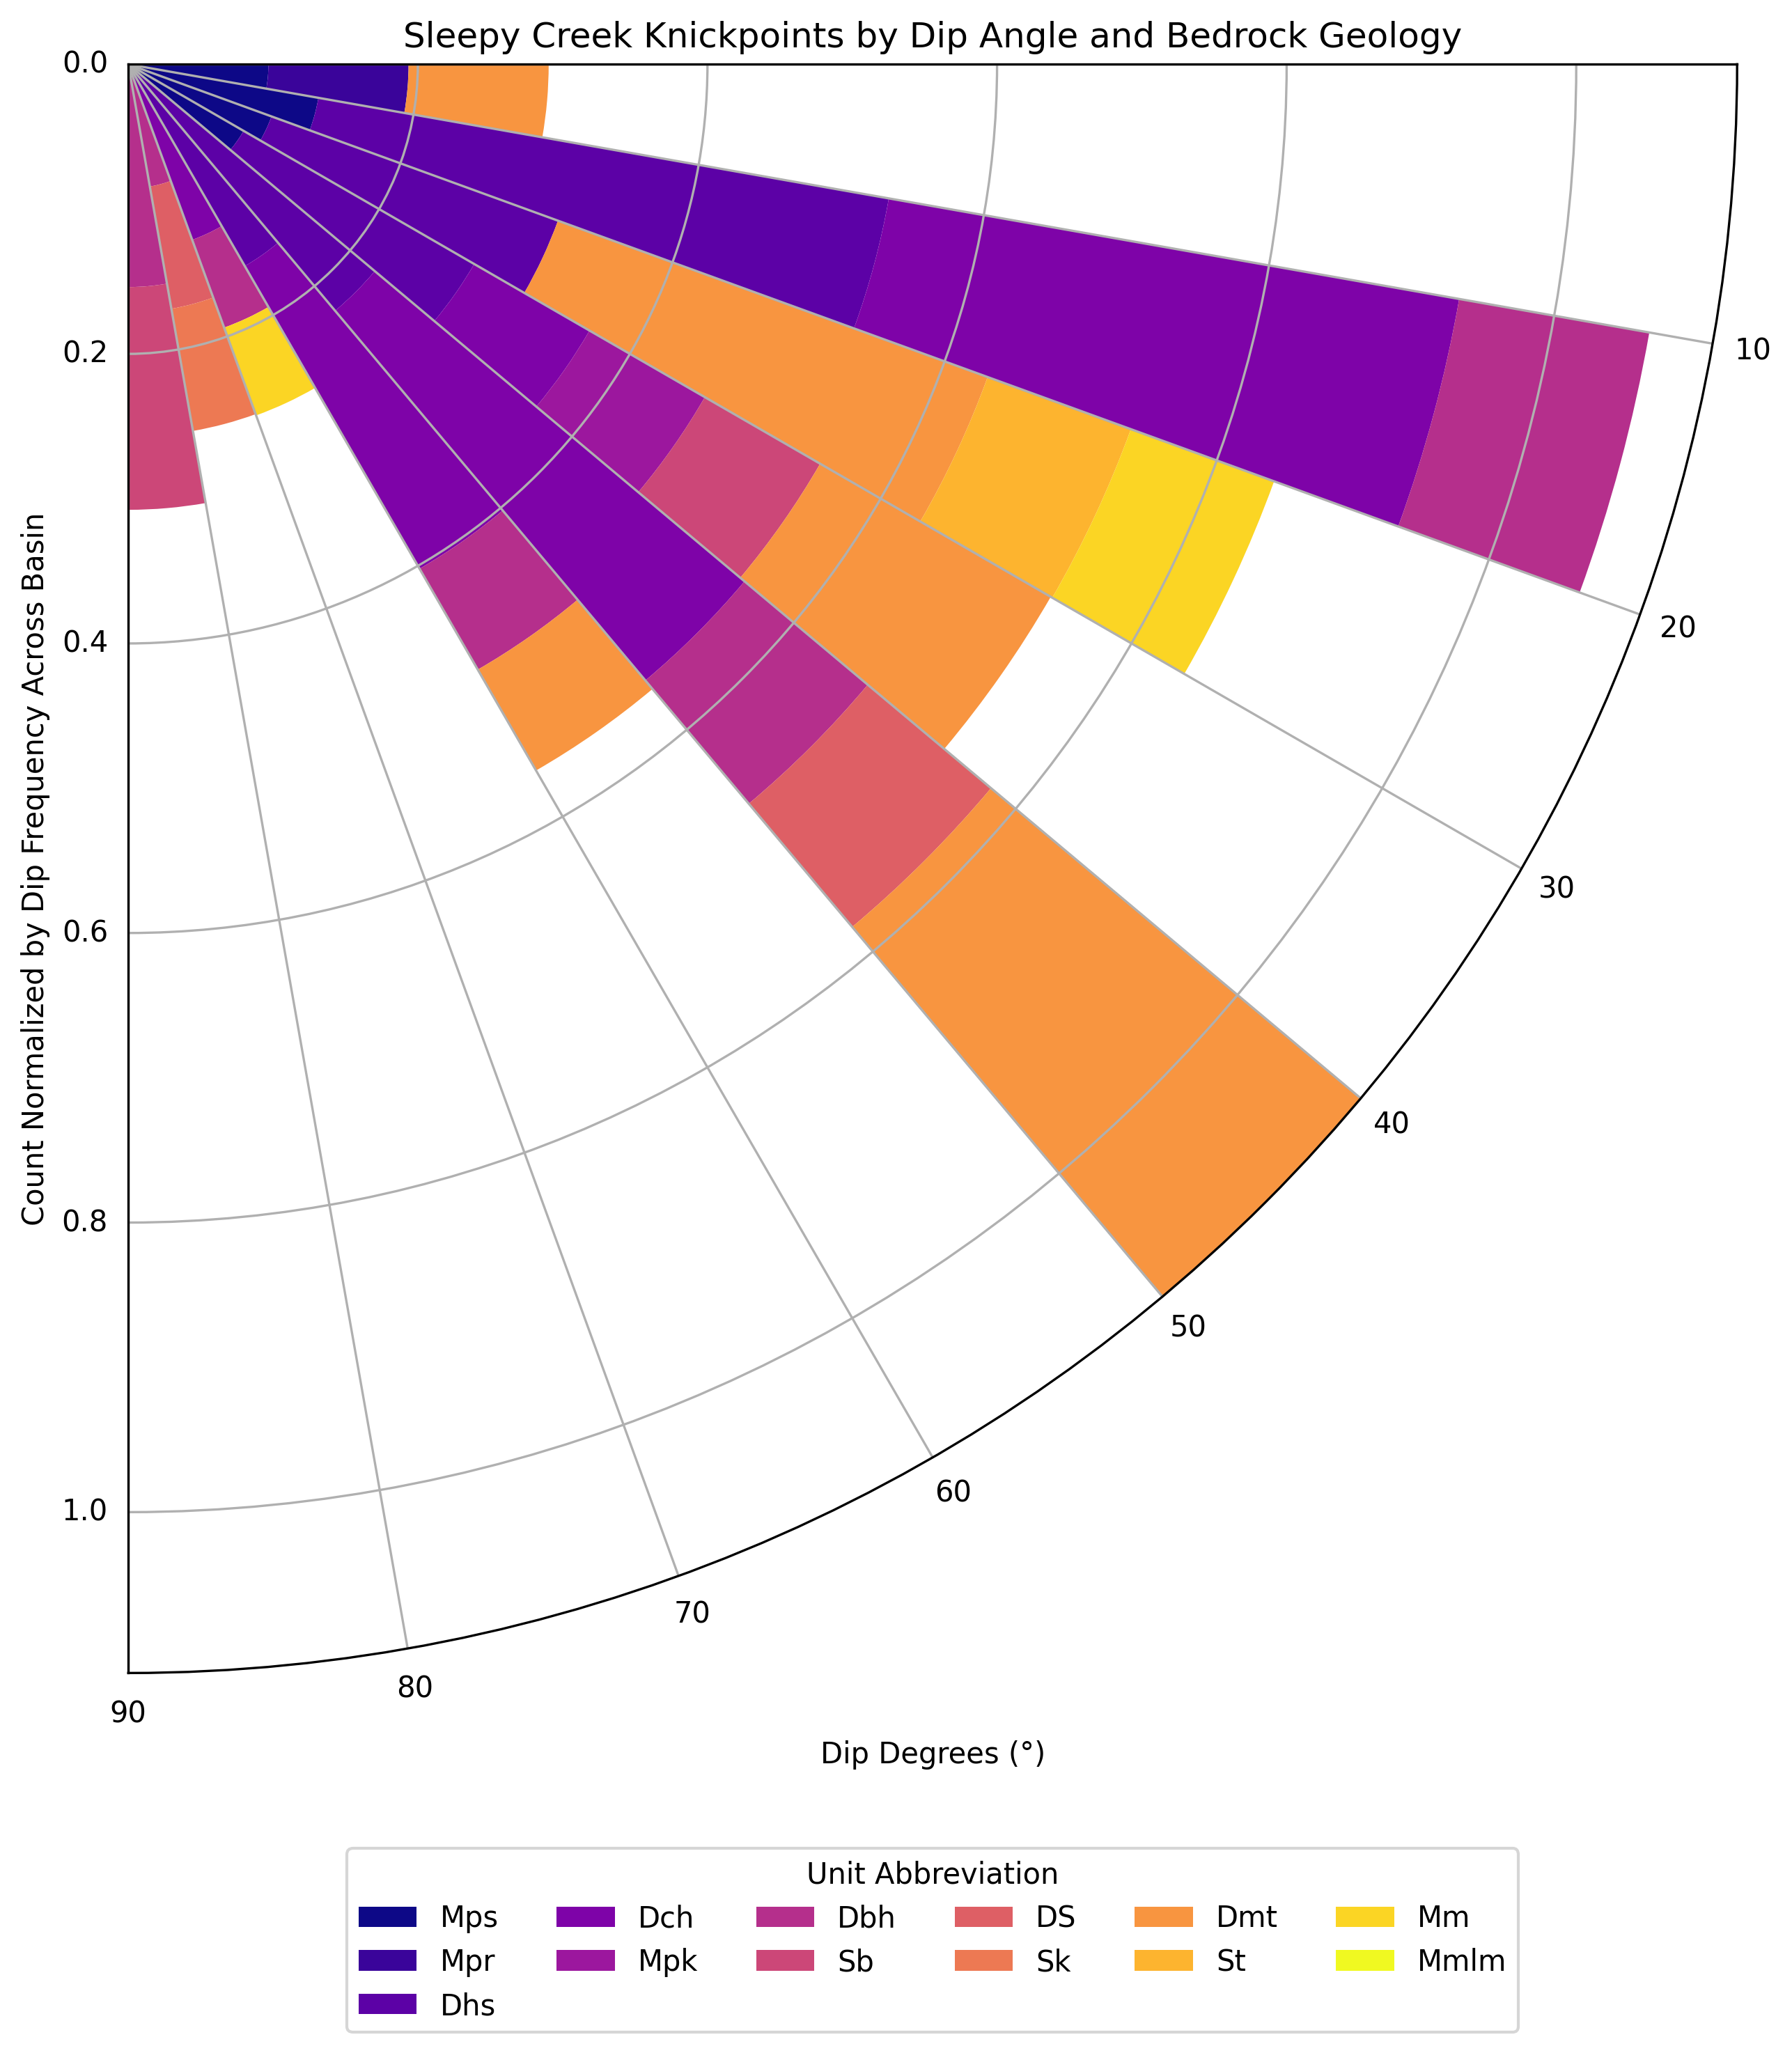

Unit 0-10 11-20     21-30     31-40 41-50    51-60     61-70     71-80  \
0  Dhs  0.0   0.0       0.0  0.032258   0.0      0.0       0.0  0.184615   
0  Dch  0.0   0.0       0.0       0.0   0.0      0.0       0.0  0.184615   
0  Dbh  0.0   0.0       0.0       0.0   0.0      0.0  0.027027       0.0   
0  Mpr  0.0   0.0       0.0       0.0  0.02      0.0       0.0       0.0   
0  Dmt  0.0   0.0  0.010526       0.0   0.0  0.03125       0.0  0.184615   
0  Dmn  0.0   0.0       0.0  0.032258   0.0      0.0       0.0       0.0   

      81-90  
0       0.0  
0  0.392157  
0  0.294118  
0       0.0  
0  0.294118  
0       0.0

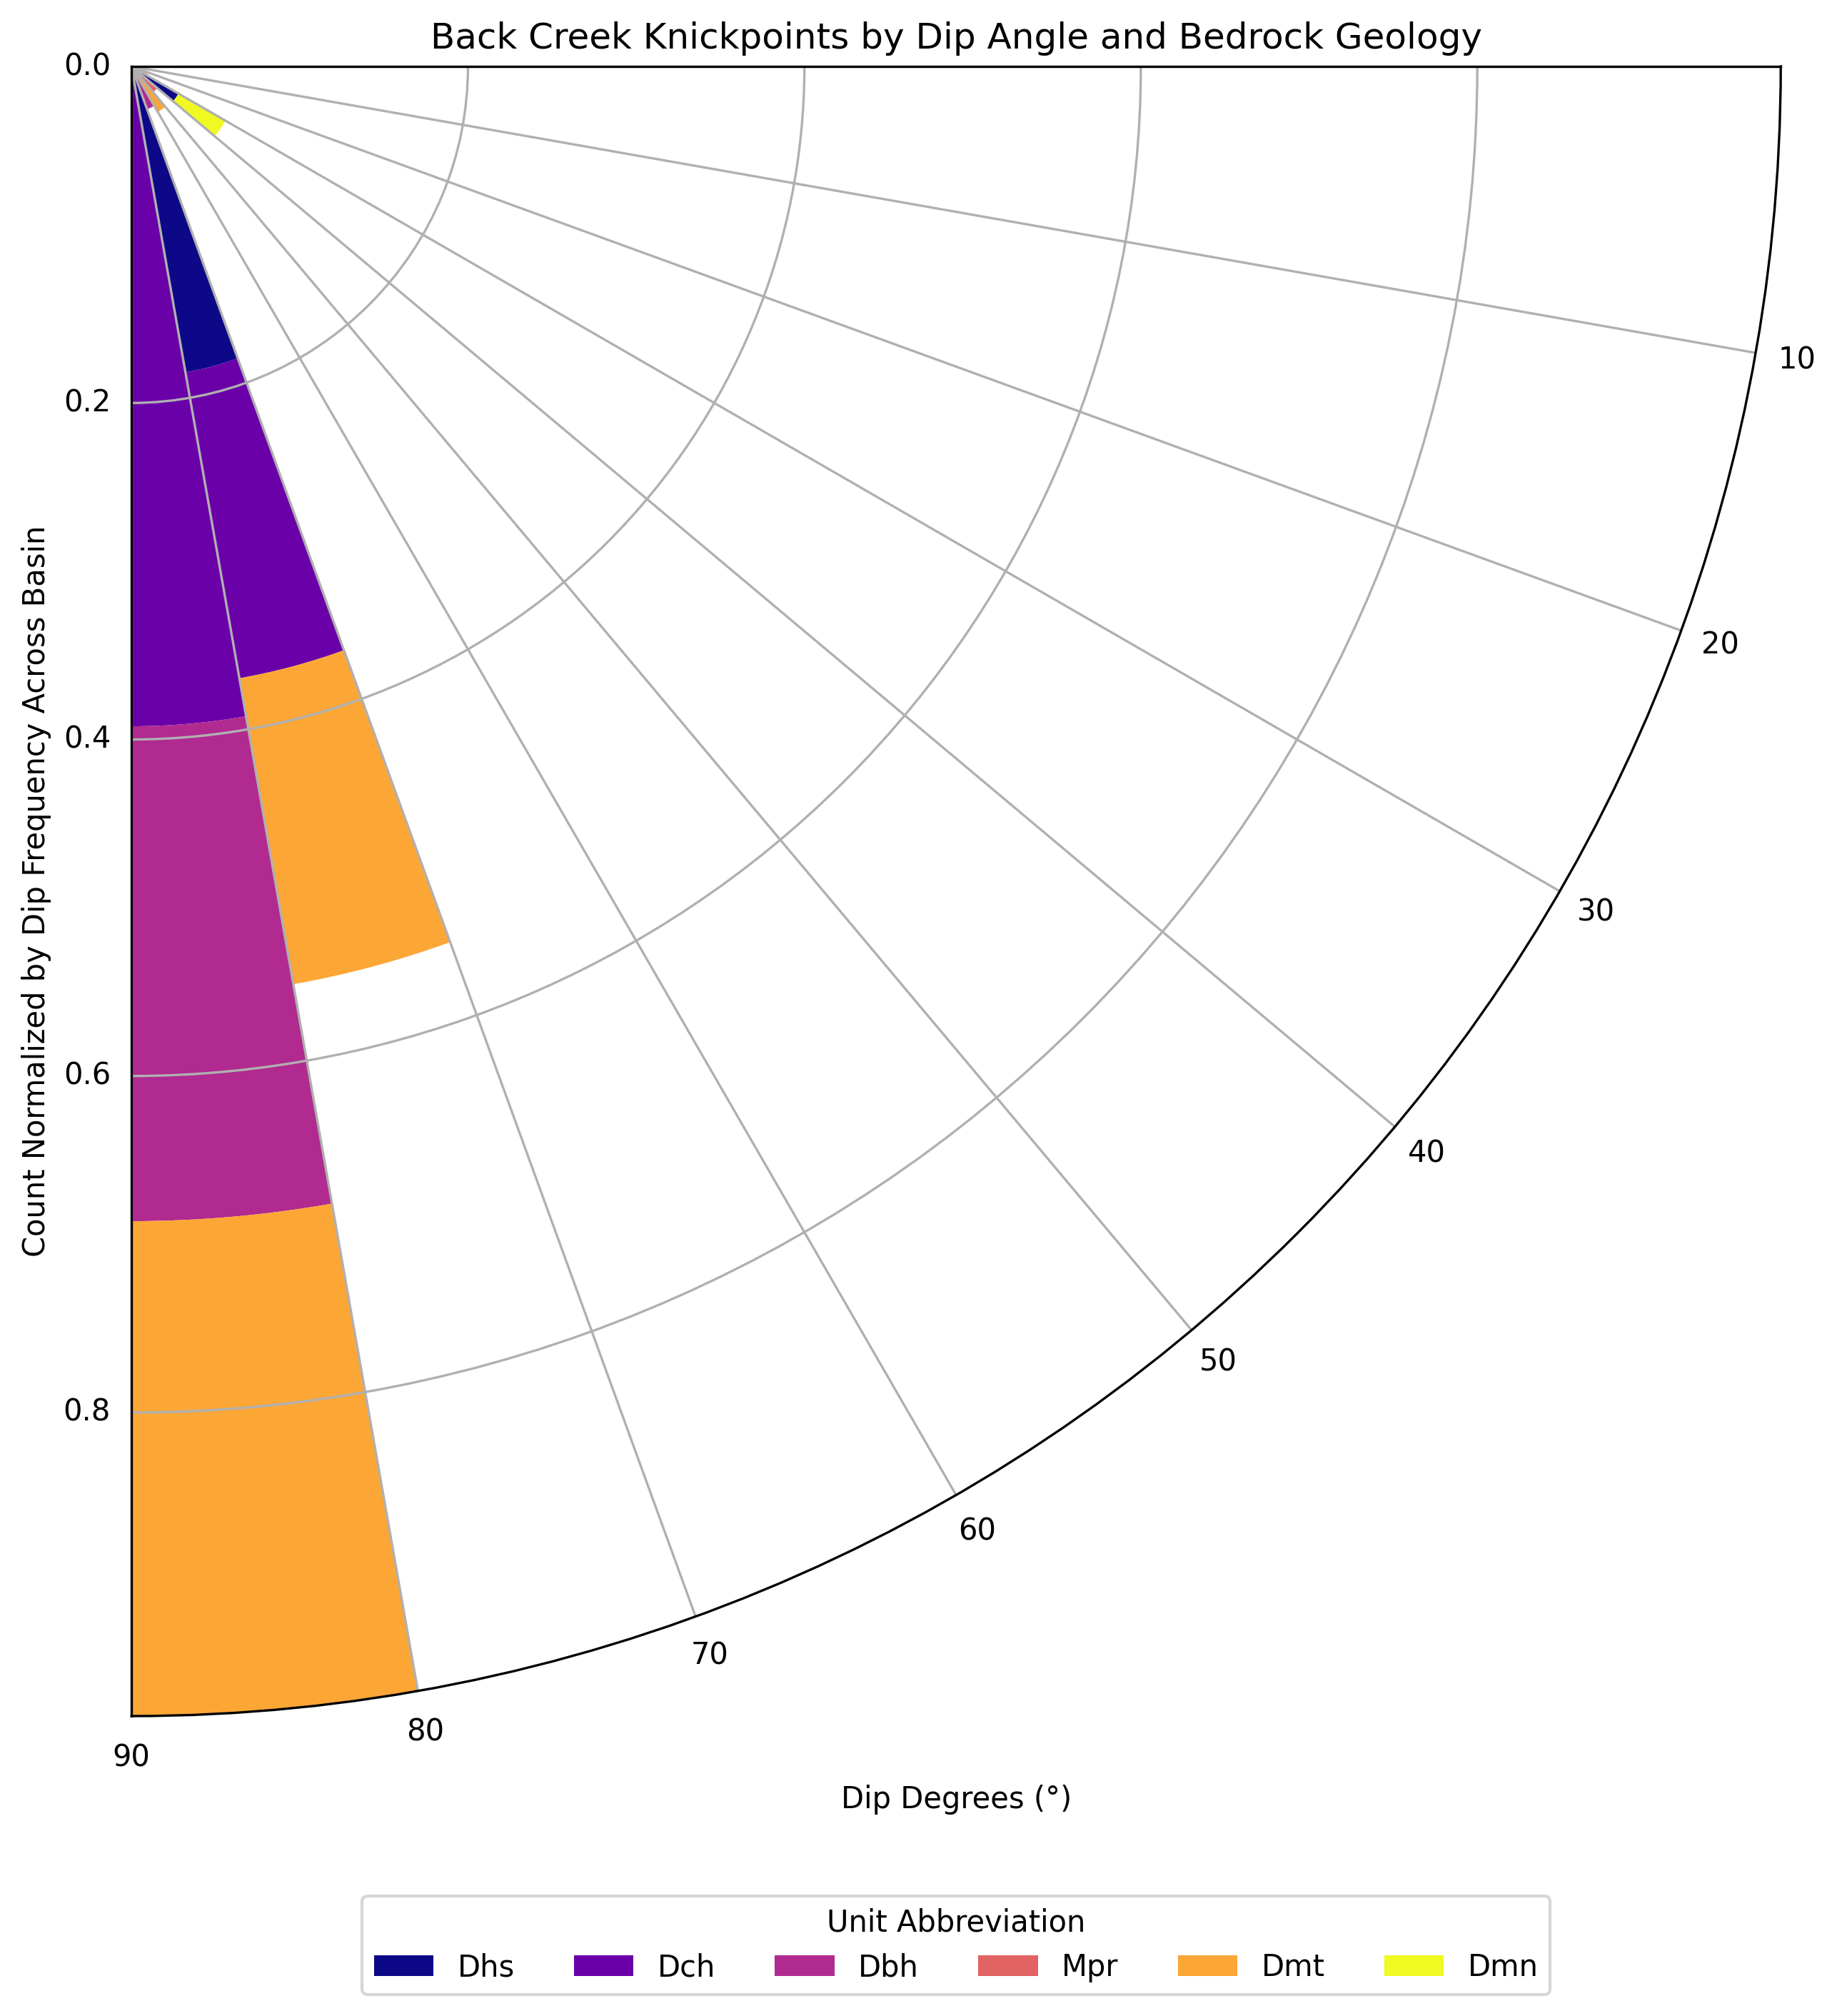

Unit  0-10 11-20 21-30 31-40     41-50     51-60 61-70    71-80     81-90
0    Sto   0.0   0.0   0.0   0.0       0.0  0.043478   0.0  0.09375       0.0
0   Dggf   0.0   0.0   0.0   0.0       0.0  0.043478  0.12  0.09375       0.0
0     On   0.0   0.0   0.1   0.0       0.0       0.0   0.0      0.0       0.0
0     Or   0.0   0.0   0.1   0.0       0.0       0.0  0.12      0.0  0.038462
0     Mg  0.08   0.0   0.0   0.0       0.0       0.0   0.0      0.0       0.0
0  Smckr   0.0   0.0   0.1   0.0       0.0       0.0   0.0      0.0       0.0
0    Swc   0.0   0.0   0.0   0.0       0.0       0.0  0.12      0.0       0.0
0     St   0.0   0.0   0.0   0.0       0.0       0.0   0.0  0.09375       0.0
0    Dhl  0.08   0.0   0.1   0.0  0.020408       0.0   0.0      0.0       0.0

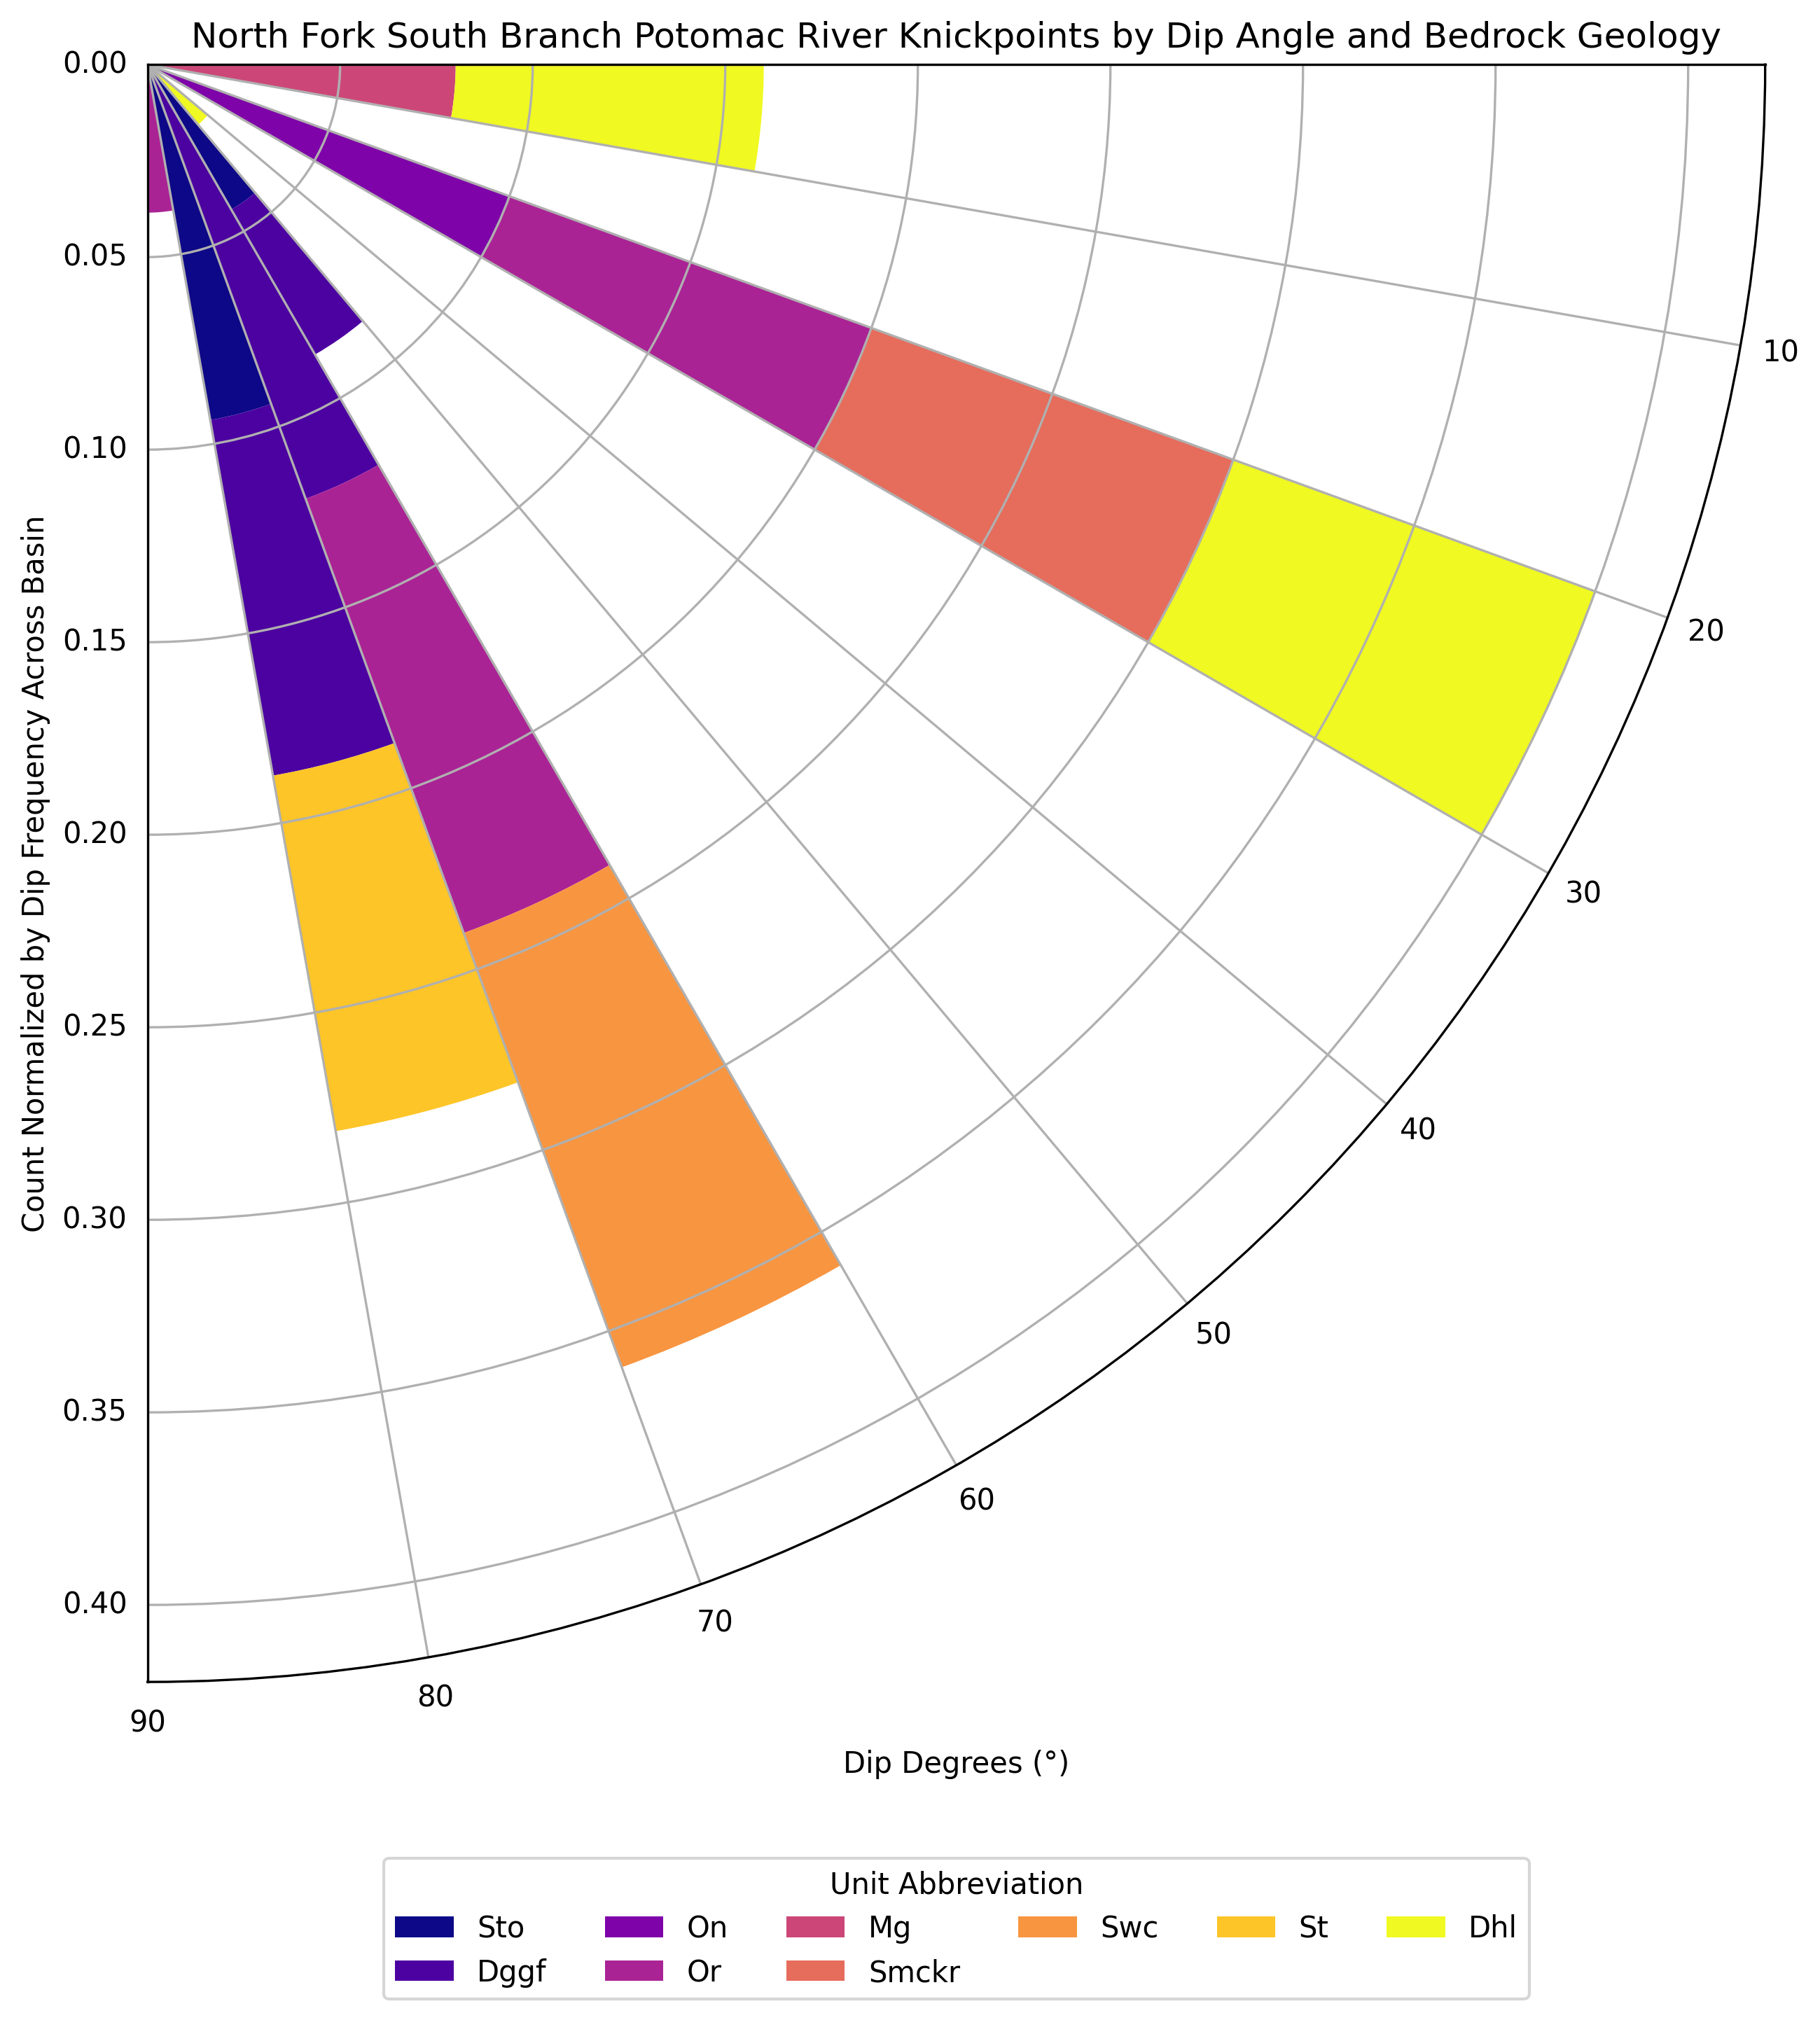

Unit      0-10     11-20     21-30     31-40     41-50     51-60  \
0    Sto       0.0       0.0       0.0       0.0       0.0  0.340909   
0    Swc       0.0  0.051724       0.0  0.019608       0.0       0.0   
0   Dggf       0.0  0.051724       0.0       0.0       0.0       0.0   
0     Or       0.0       0.0       0.0       0.0       0.0  0.113636   
0    Dhs       0.0  0.051724       0.0       0.0  0.044444       0.0   
0     On       0.0       0.0  0.065217       0.0       0.0       0.0   
0     Mg  0.033333       0.0       0.0       0.0       0.0       0.0   
0    Srh       0.0       0.0       0.0       0.0       0.0  0.113636   
0  Smckr       0.0       0.0  0.065217       0.0       0.0       0.0   
0     Oj       0.0       0.0       0.0       0.0  0.044444       0.0   
0     St       0.0       0.0       0.0       0.0       0.0       0.0   
0     Db       0.0       0.0       0.0       0.0       0.0       0.0   
0     Do       0.0       0.0       0.0       0.0       0.0       0.0   
0    Dhl       0.0       0.0  0.065217       0.0       0.0       0.0   

      61-70     71-80     81-90  
0       0.0  0.114286       0.0  
0  0.222222       0.0       0.0  
0       0.0       0.0  0.192308  
0       0.0       0.0  0.384615  
0       0.0       0.0       0.0  
0       0.0       0.0       0.0  
0       0.0       0.0       0.0  
0       0.0       0.0  0.192308  
0       0.0       0.0       0.0  
0       0.0       0.0  0.192308  
0       0.0  0.114286       0.0  
0       0.0  0.114286       0.0  
0       0.0  0.114286       0.0  
0  0.111111       0.0       0.0

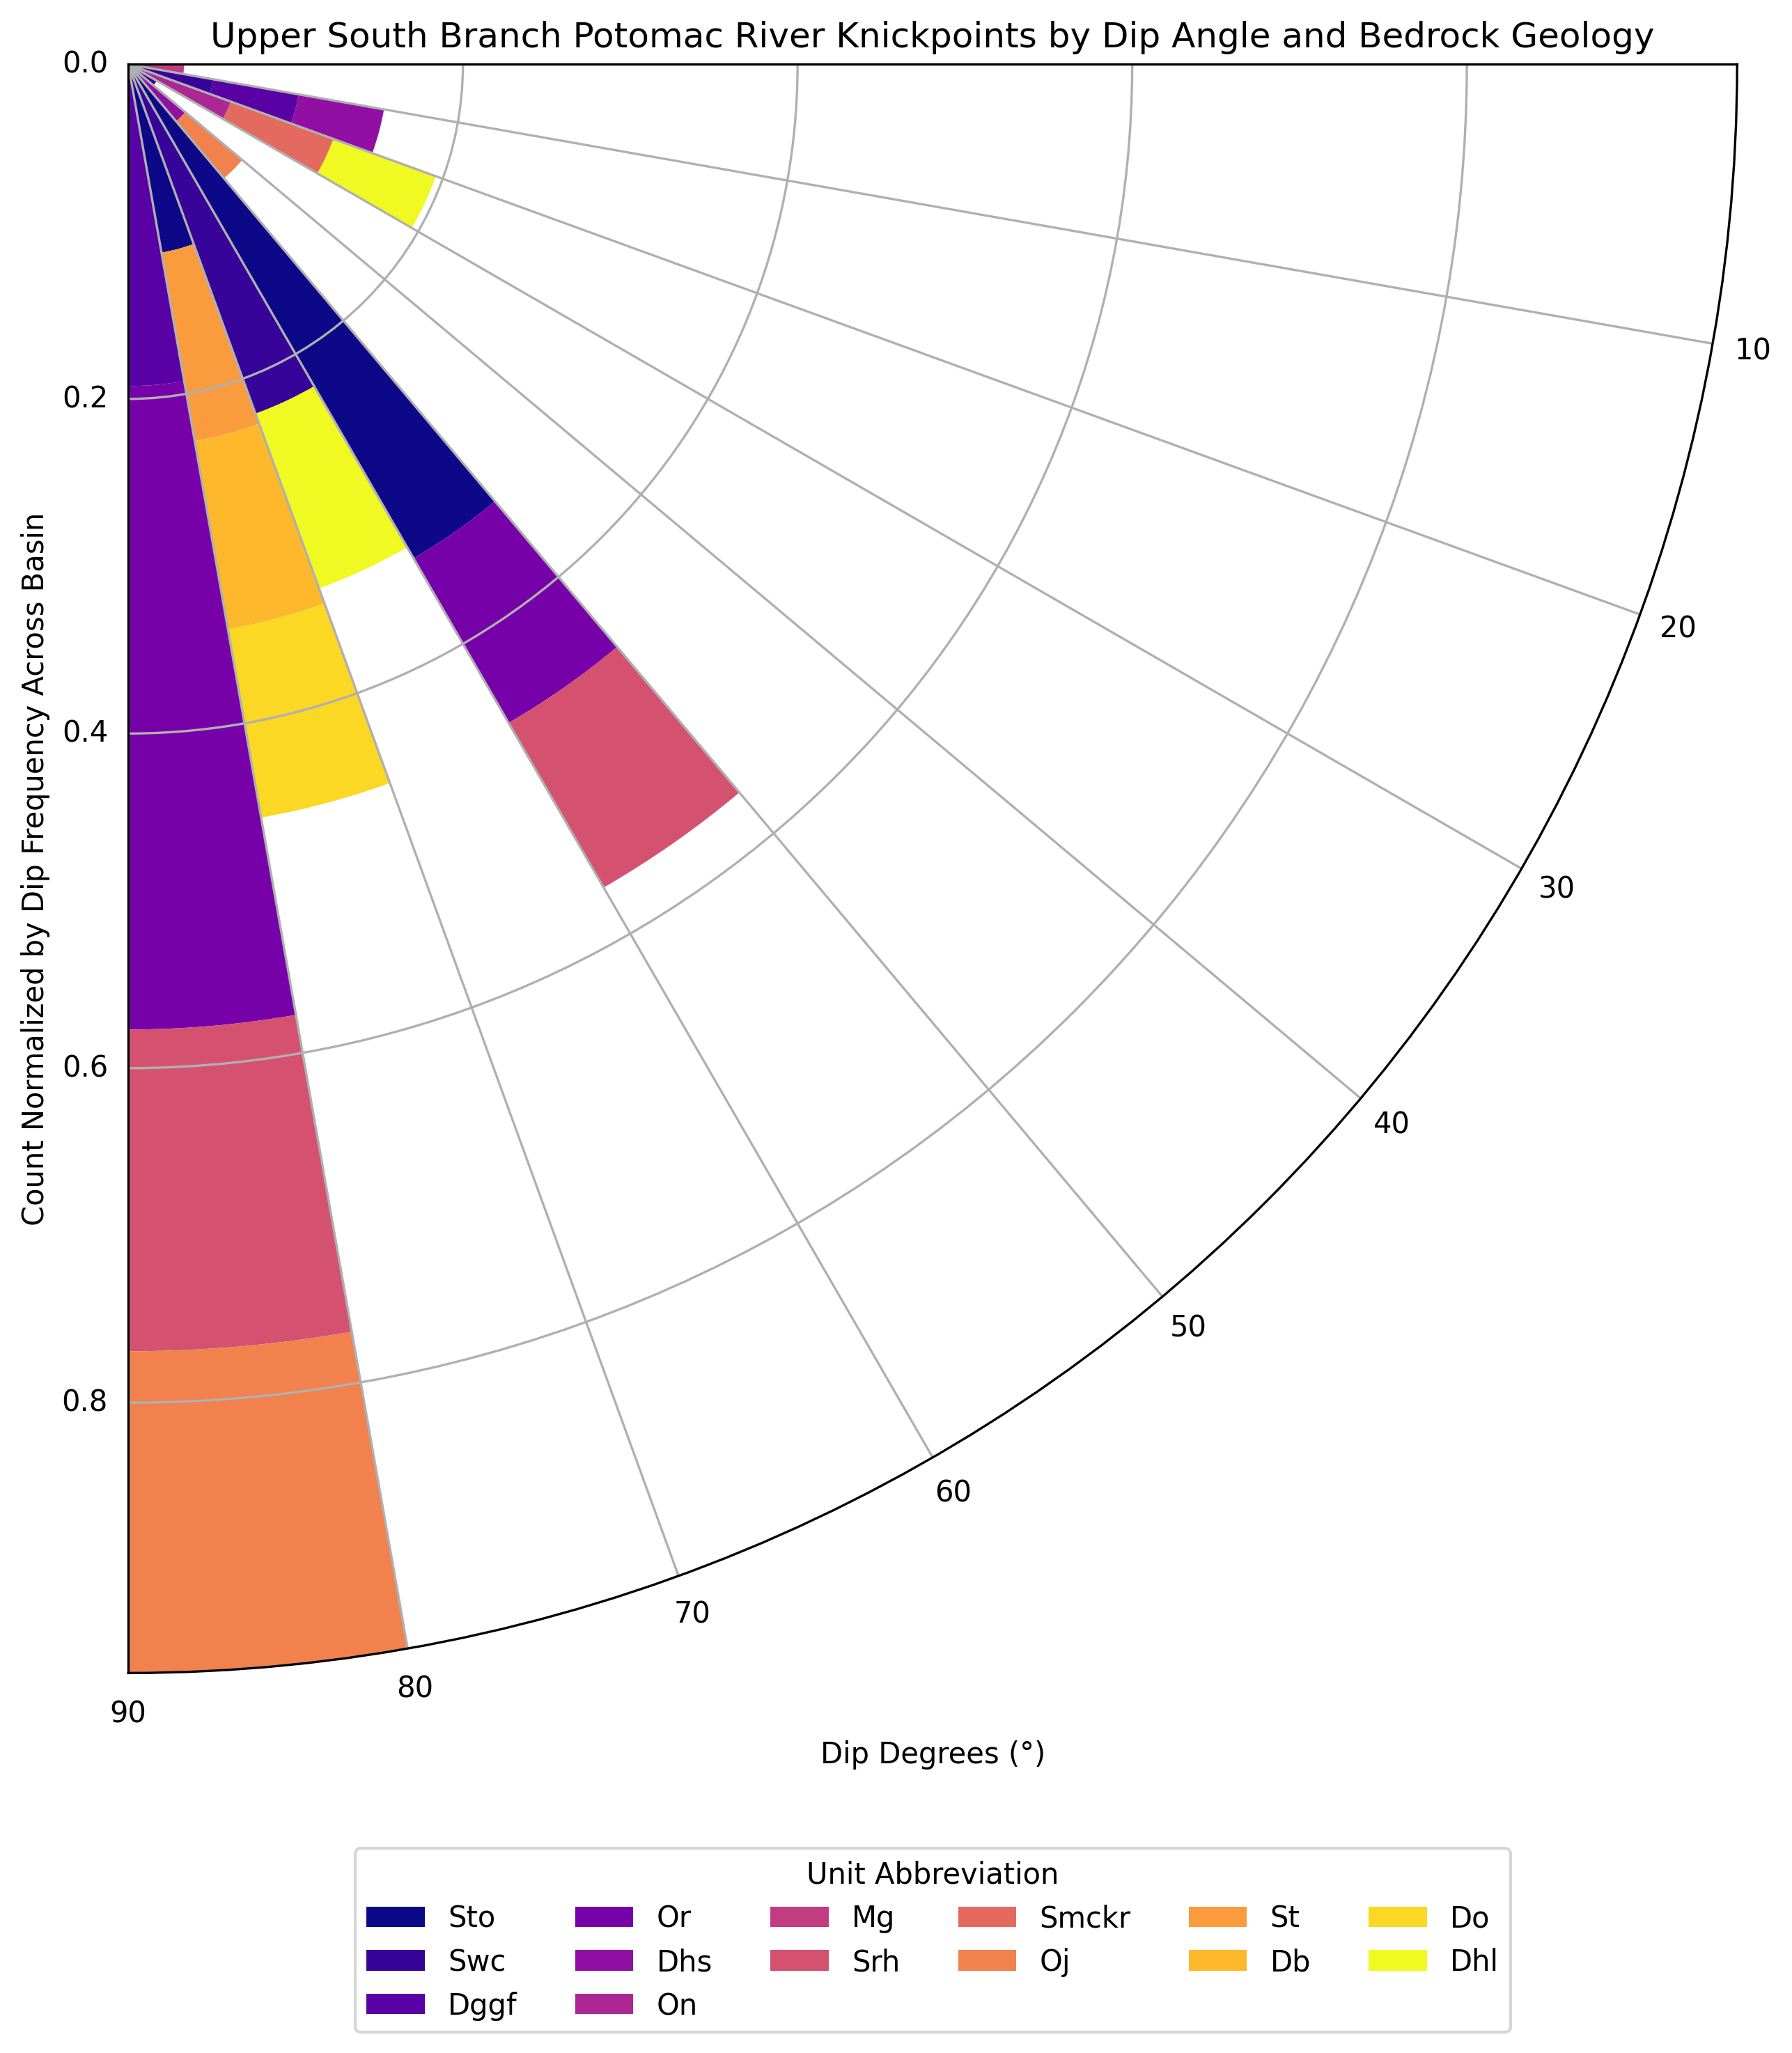

Unit      0-10     11-20     21-30     31-40     41-50     51-60  \
0     Db       0.0       0.0       0.0       0.0       0.0  0.118812   
0   Dggf       0.0  0.058333  0.015625  0.038462  0.021978  0.118812   
0    Dhl  0.006667  0.029167       0.0  0.076923       0.0       0.0   
0    Sto       0.0       0.0       0.0       0.0       0.0       0.0   
0    Swc       0.0  0.029167  0.015625  0.038462       0.0       0.0   
0    Srh       0.0       0.0       0.0  0.038462  0.021978       0.0   
0    Dmn       0.0       0.0  0.015625  0.038462       0.0       0.0   
0     Do       0.0  0.029167  0.015625  0.115385       0.0  0.059406   
0     Oj       0.0       0.0       0.0       0.0  0.021978       0.0   
0  Smckr       0.0  0.029167       0.0       0.0  0.021978       0.0   
0    Dhs       0.0       0.0       0.0  0.038462       0.0       0.0   
0     St       0.0  0.029167       0.0       0.0       0.0  0.059406   

      61-70     71-80     81-90  
0       0.0  0.135593       0.0  
0       0.0       0.0       0.0  
0  0.026316  0.067797  0.047619  
0       0.0  0.067797       0.0  
0       0.0       0.0       0.0  
0       0.0       0.0       0.0  
0       0.0       0.0  0.047619  
0       0.0       0.0       0.0  
0       0.0       0.0       0.0  
0  0.026316       0.0       0.0  
0       0.0       0.0       0.0  
0       0.0       0.0       0.0

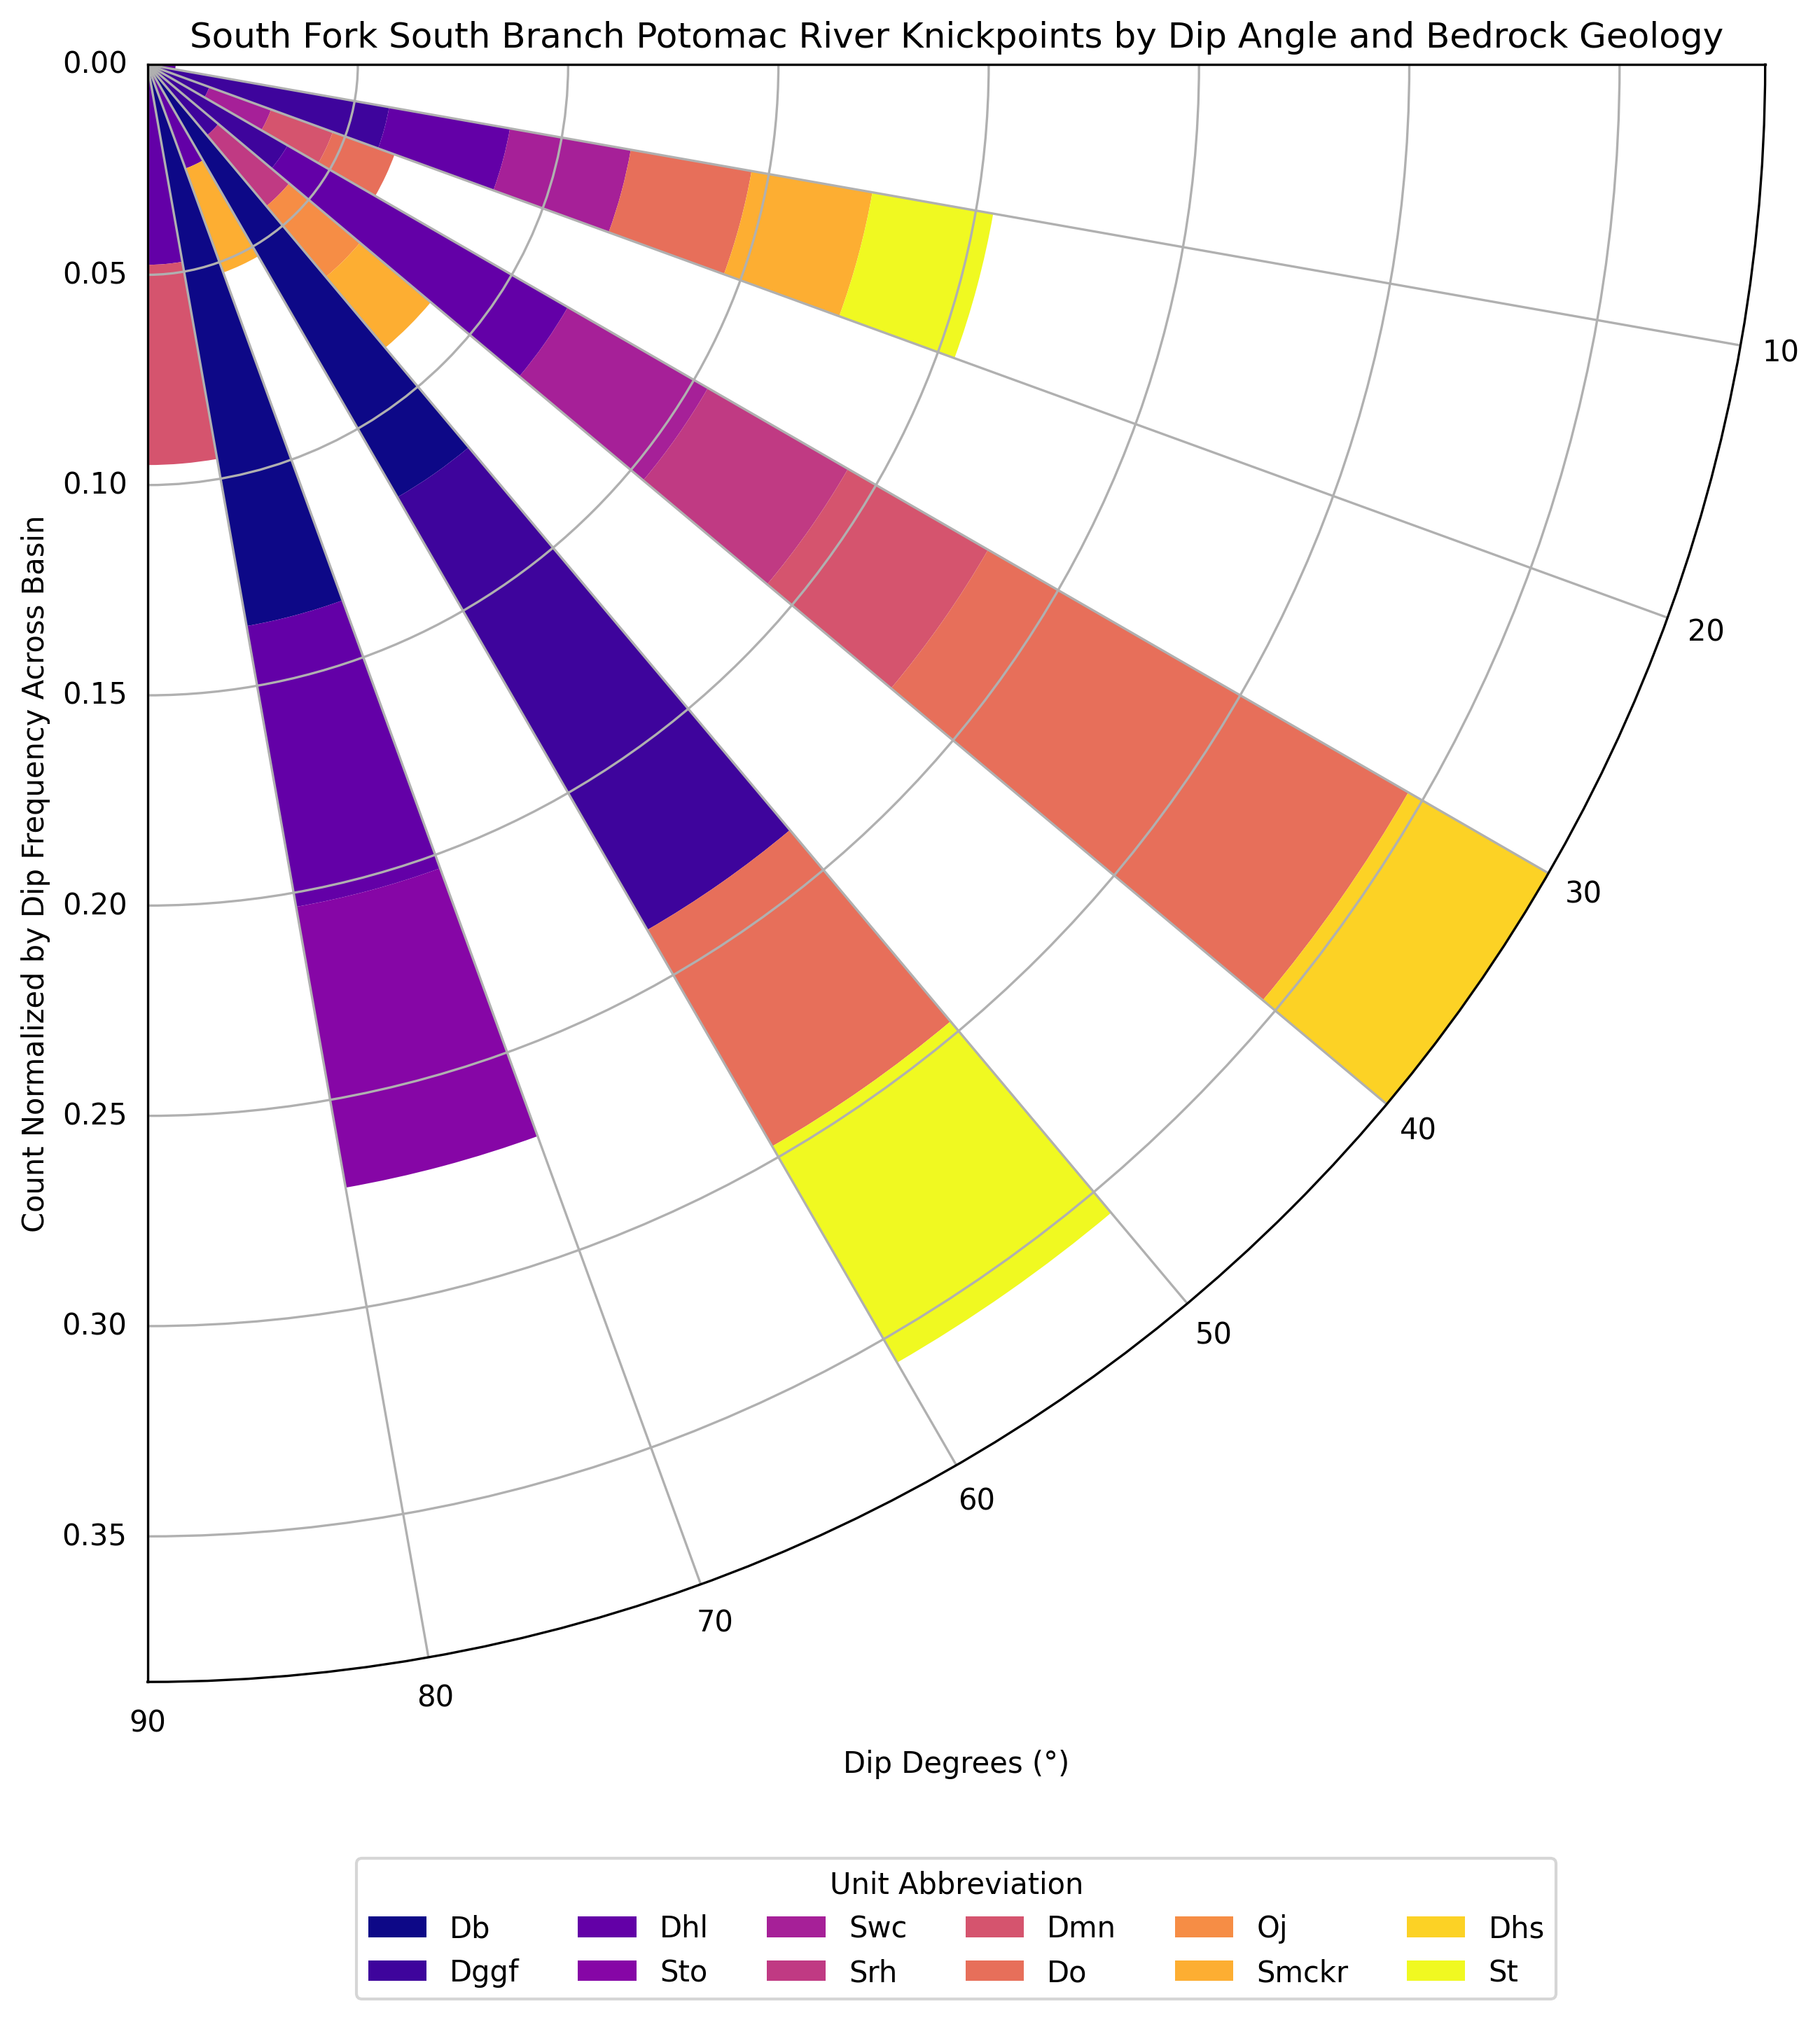

Unit 0-10     11-20 21-30  31-40     41-50 51-60     61-70 71-80 81-90
0    Dm  0.0       0.0   0.0    0.0  0.210526   0.5       0.0   0.5   0.0
0    Db  0.0       0.0  0.15    0.0       0.0   0.0  0.333333   0.5   0.0
0  Dggf  0.0  0.111111  0.15   0.25       0.0   0.0       0.0   0.0   0.0
0    Oj  0.0       0.0  0.15  0.125       0.0   0.5       0.0   0.0   0.0
0    St  0.0  0.111111   0.0    0.0       0.0   0.0       0.0   0.0   0.0

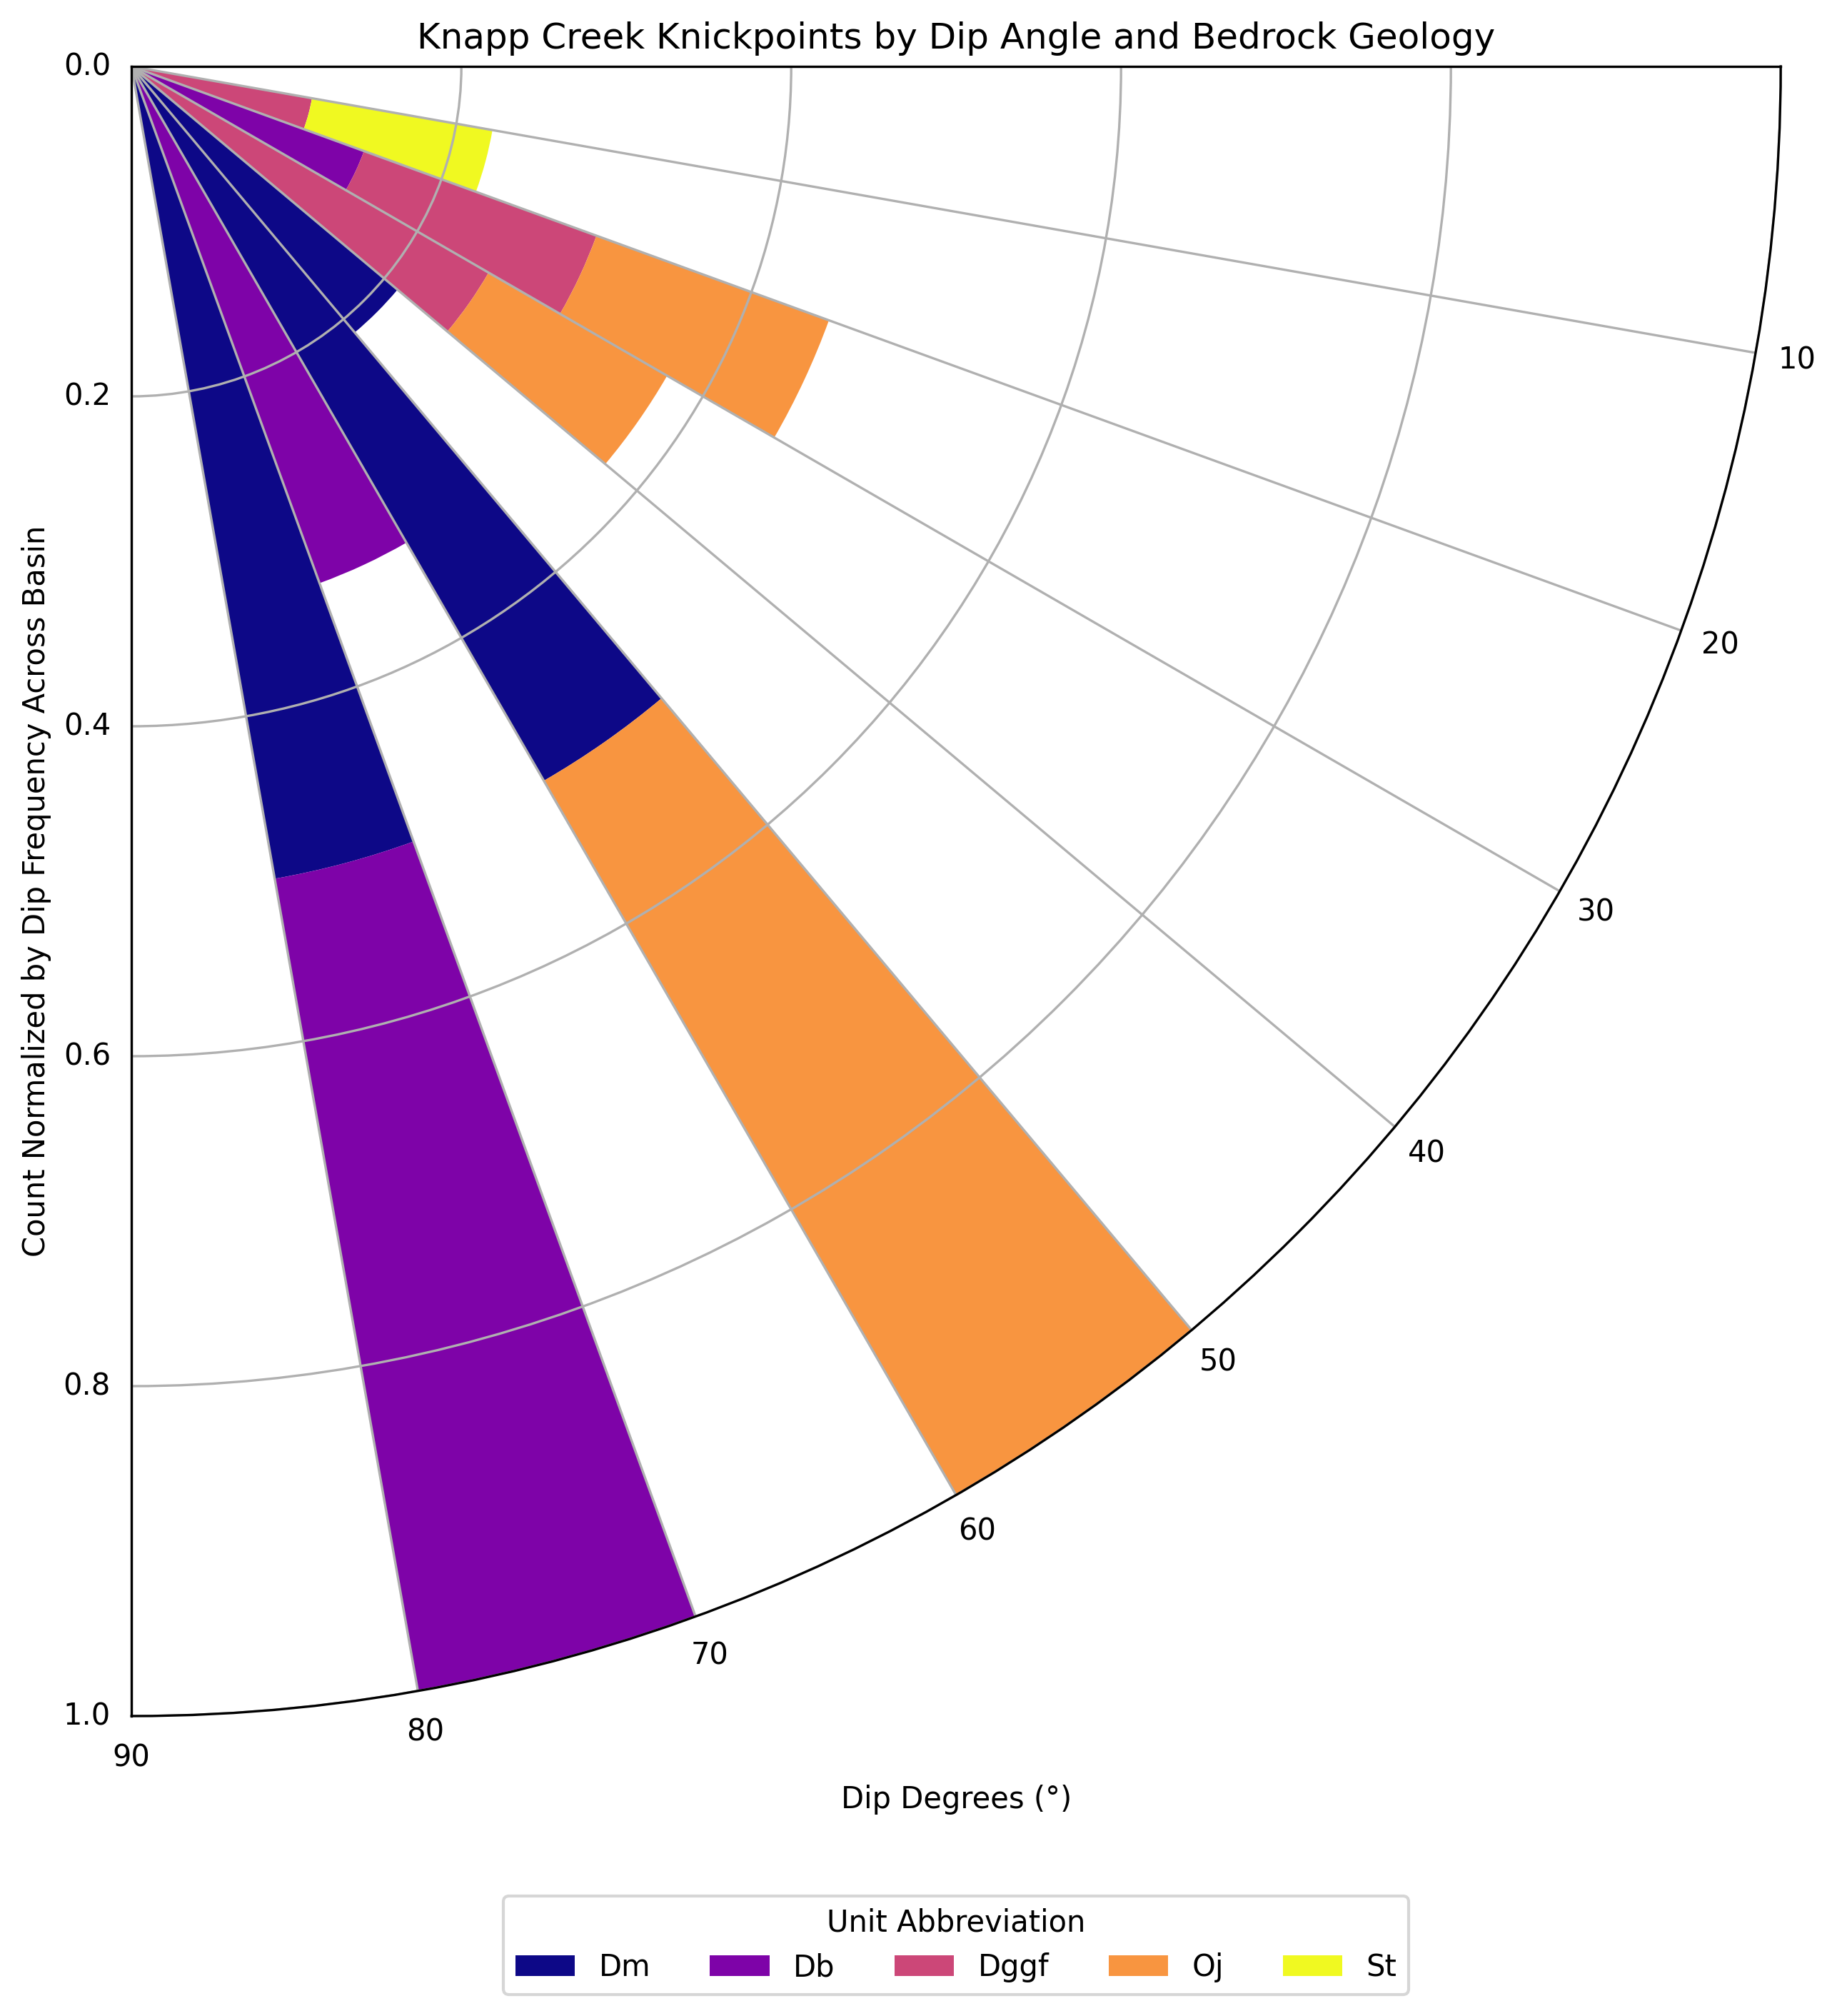

Unit      0-10 11-20     21-30     31-40     41-50     51-60     61-70  \
0     Mh  1.052632   0.0       0.0       0.0       0.0       0.0  0.176471   
0     Mg       0.0   0.0       0.0  0.181818  0.842105       0.0  0.352941   
0     Db       0.0   0.0  0.153846       0.0       0.0   0.37037       0.0   
0    Mbf       0.0   0.0       0.0       0.0       0.0  0.185185       0.0   
0     Ob       0.0   0.0  0.153846  0.181818       0.0  0.185185       0.0   
0     Mp       0.0   0.0       0.0       0.0       0.0  0.185185       0.0   
0  Mhlsg  0.263158   0.0       0.0       0.0       0.0       0.0       0.0   

   71-80 81-90  
0  0.125   0.0  
0    0.0   0.0  
0    0.0   0.0  
0    0.0   0.4  
0    0.0   0.4  
0    0.0   0.0  
0    0.0   0.0

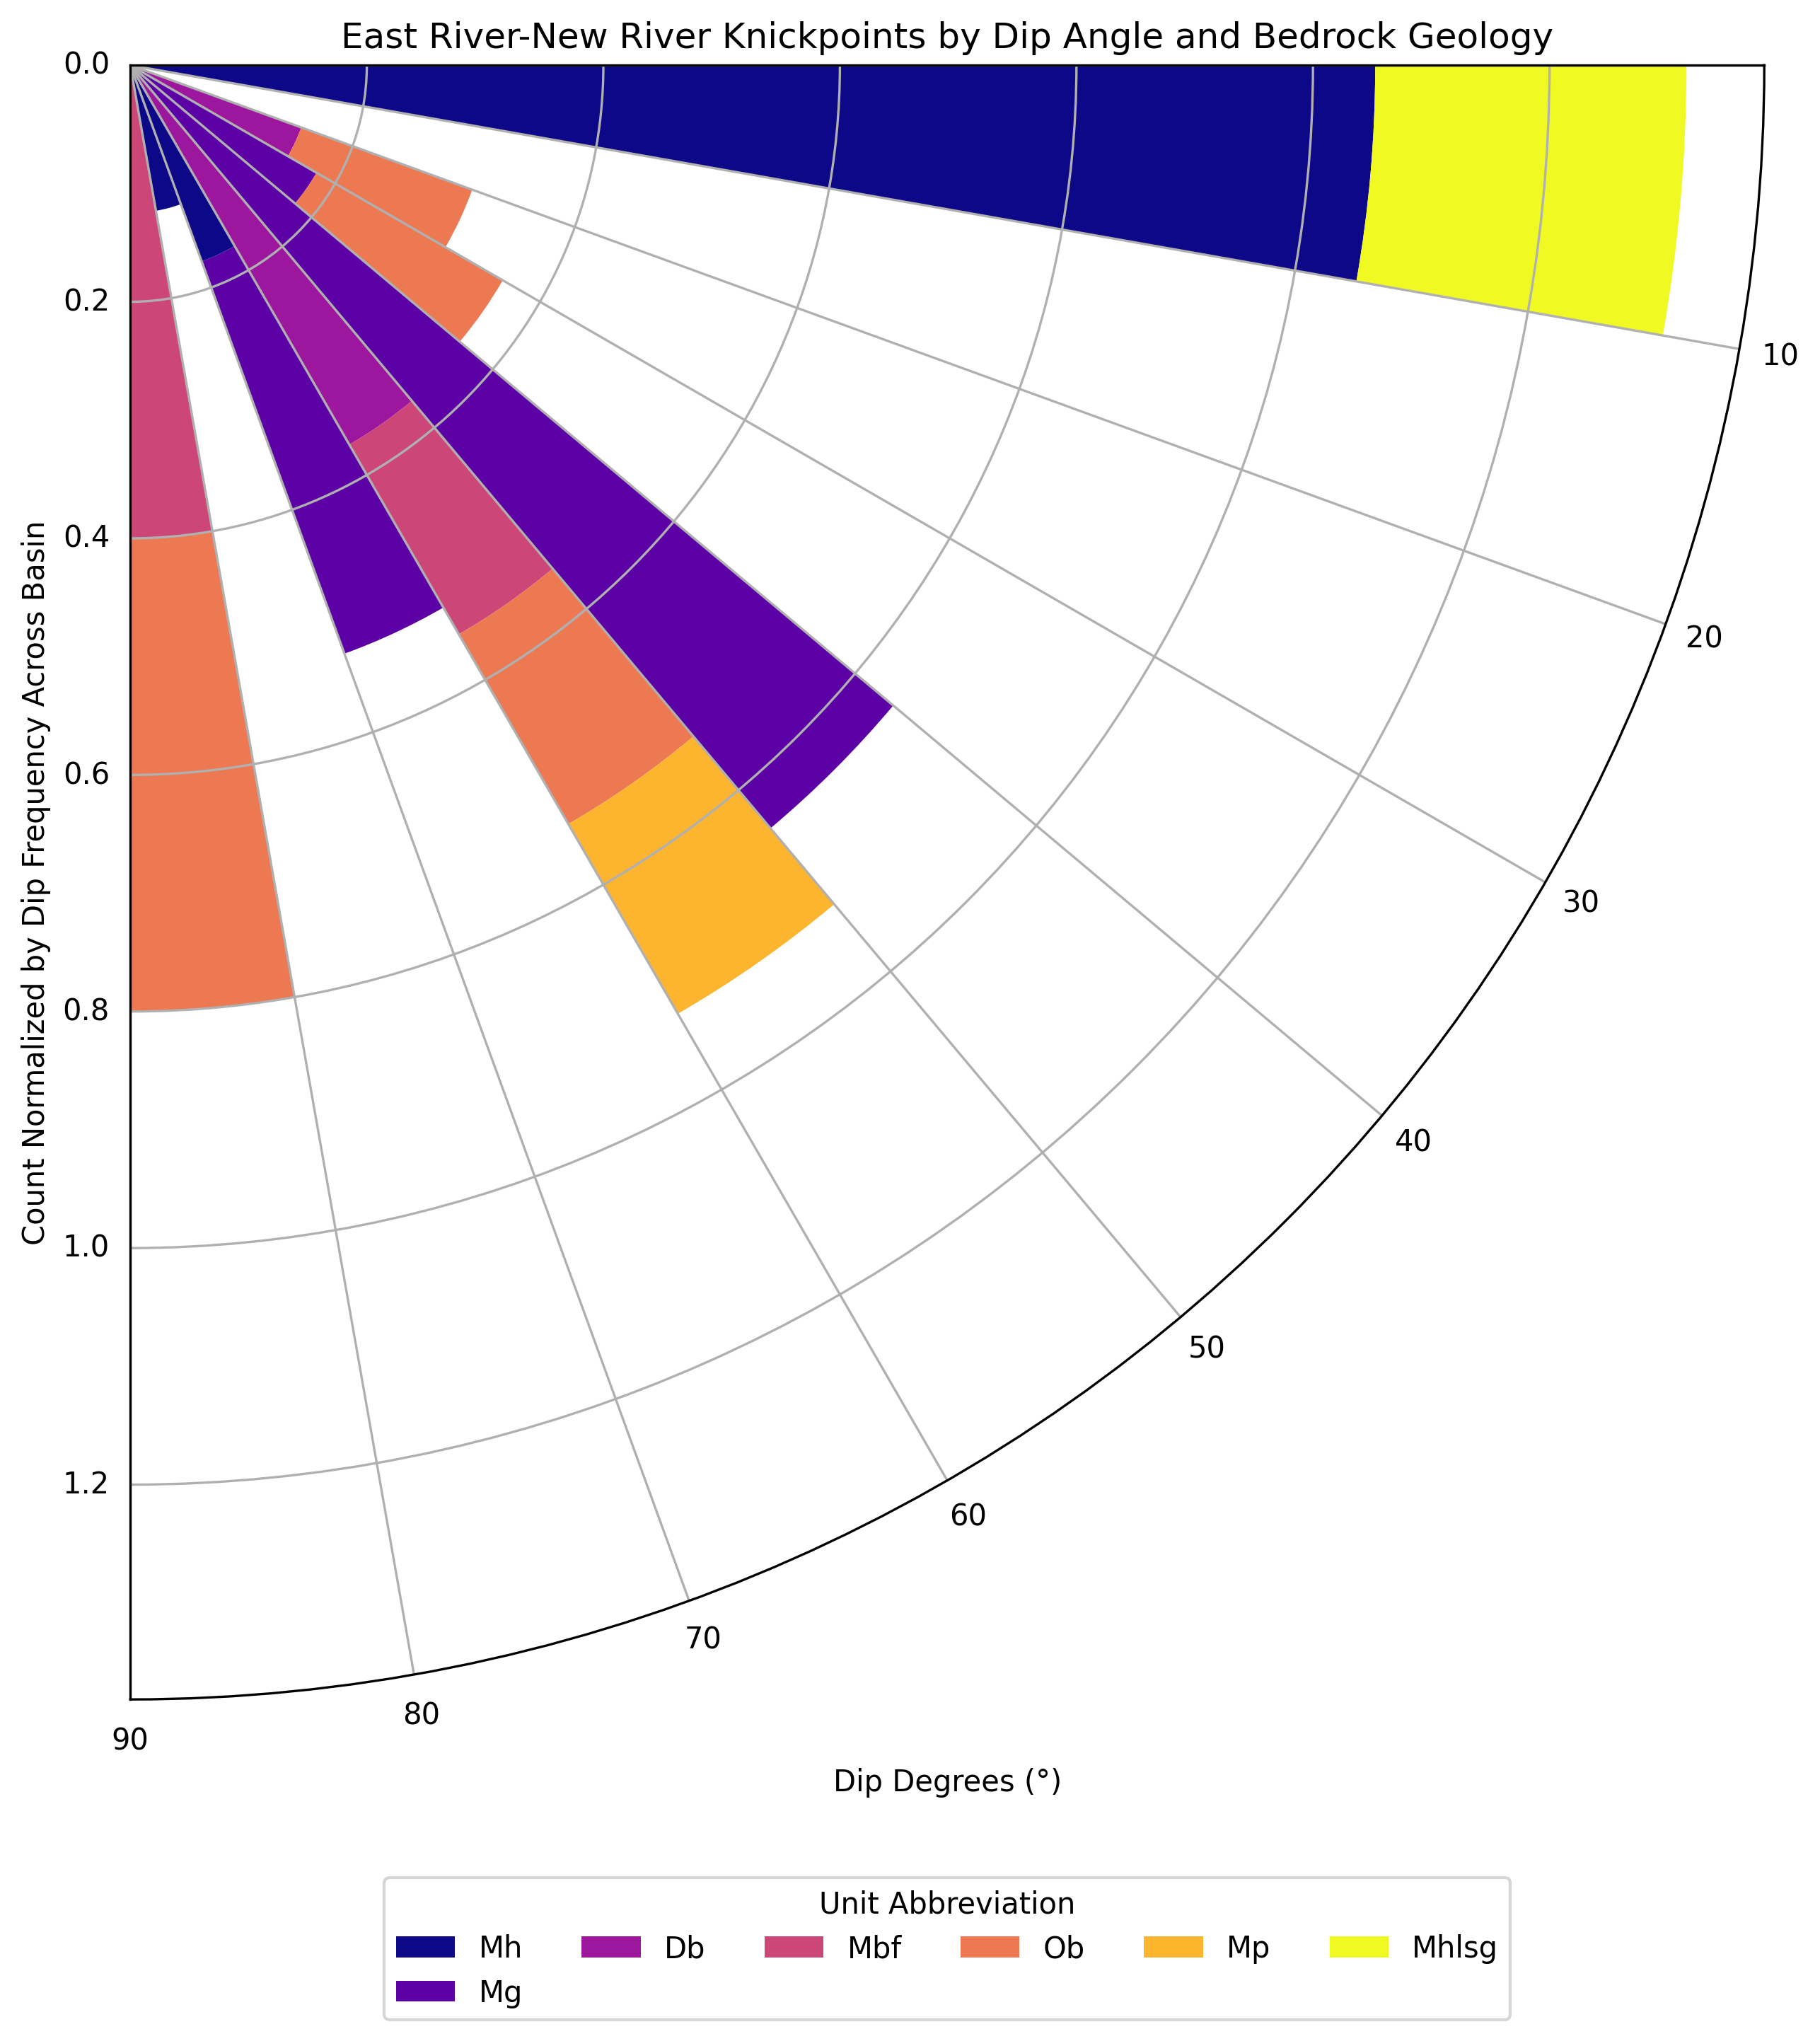

In [36]:
for kp_df, ksn_df in zip(kps_dip_strat_fin, ksn_gdfs_list):

    test_ksn = ksn_gdfs_list[0]
    b_nos_ksn = np.asarray(ksn_df.groupby('dip_bin').count()['dip_angle'])

    b_nos_kp = np.asarray(kp_df.groupby('dip_bin').count()['dip_angle'])

    dip_frqs = (b_nos_kp/b_nos_ksn)

    data_by_geol = pd.DataFrame(columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
    for x in kp_df.unit_abbrv.unique():
        bin_count = kp_df[kp_df.unit_abbrv == x].groupby('dip_bin').size().values * dip_frqs
        new_row = pd.DataFrame([x]+list(bin_count)).T
        new_row.columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
        data_by_geol = pd.concat([data_by_geol, new_row])
    display(data_by_geol)

    fig = plt.figure(figsize=(10, 10), dpi=300)

    num_discrete_levels = len(data_by_geol)
    discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

    ax = fig.add_subplot(111, polar=True)
    ax.set_thetamin(270)
    ax.set_thetamax(360)
    labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
    perim = -np.pi/2
    width = (2*np.pi/36)
    start_point = (perim-.5*width)
    theta = np.arange(width/2, np.abs(start_point), step = width)
    theta = [number * -1 for number in theta]
    ax.set_xticklabels(labels)
    bottom = 0
    for i in range(0, len(data_by_geol)):
        if i==0:
            ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
            bottom = data_by_geol.iloc[0][1:].values
        else:
            ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
            bottom += data_by_geol.iloc[i][1:].values

    ax.set_title(f'{str(kp_df.wshed.iloc[0]).replace("_"," ")} Knickpoints by Dip Angle and Bedrock Geology')
    ax.set_xlabel('Dip Degrees (°)')
    ax.set_ylabel('Count Normalized by Dip Frequency Across Basin')

    plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Unit Abbreviation')
    # plt.savefig(f'{PATH}/{PROJ_TITLE}/radial_plots/{df_to_b_graphed.wshed.iloc[0]}_radial_geol.png', bbox_inches = 'tight')
    plt.show()
    plt.close()

In [ ]:
try:
    os.mkdir(f'{PATH}/{PROJ_TITLE}/radial_plots')
except FileExistsError:
    print('File exists')

for df_to_b_graphed in kps_dip_strat_fin:

    # Sort our data by the underlying geology.
    data_by_geol = pd.DataFrame(columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
    for x in df_to_b_graphed.unit_abbrv.unique():
        bin_count = df_to_b_graphed[df_to_b_graphed.unit_abbrv == x].groupby('dip_bin').size().values
        new_row = pd.DataFrame([x]+list(bin_count)).T
        new_row.columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
        data_by_geol = pd.concat([data_by_geol, new_row])
    display(data_by_geol)

    # Now by elevation
    data_by_elev = pd.DataFrame(columns = ['elev_bin', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
    for x in sorted(df_to_b_graphed.elev_bin.unique()):
        bin_count = df_to_b_graphed[df_to_b_graphed.elev_bin == x].groupby('dip_bin').size().values
        new_row = pd.DataFrame([x]+list(bin_count)).T
        new_row.columns = ['elev_bin', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
        data_by_elev = pd.concat([data_by_elev, new_row])
    display(data_by_elev)

    # Graphing
    # By geology

    # fig = plt.figure(figsize=(10, 10), dpi=300)

    # num_discrete_levels = len(data_by_geol)
    # discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

    # ax = fig.add_subplot(111, polar=True)
    # ax.set_thetamin(270)
    # ax.set_thetamax(360)
    # labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
    # perim = -np.pi/2
    # width = (2*np.pi/36)
    # start_point = (perim-.5*width)
    # theta = np.arange(width/2, np.abs(start_point), step = width)
    # theta = [number * -1 for number in theta]
    # ax.set_xticklabels(labels)
    # bottom = 0
    # for i in range(0, len(data_by_geol)):
    #     if i==0:
    #         ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
    #         bottom = data_by_geol.iloc[0][1:].values
    #     else:
    #         ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
    #         bottom += data_by_geol.iloc[i][1:].values

    # ax.set_title(f'{str(df_to_b_graphed.wshed.iloc[0]).replace("_"," ")} Knickpoints by Dip Angle and Bedrock Geology')
    # ax.set_xlabel('Dip Degrees (°)')
    # ax.set_ylabel('Count')

    # plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Unit Abbreviation')
    # # plt.savefig(f'{PATH}/{PROJ_TITLE}/radial_plots/{df_to_b_graphed.wshed.iloc[0]}_radial_geol.png', bbox_inches = 'tight')
    # plt.show()
    # plt.close()


    # # By elevation.
    # fig = plt.figure(figsize=(10, 10), dpi=300)

    # num_discrete_levels = len(data_by_elev)
    # discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

    # ax = fig.add_subplot(111, polar=True)
    # ax.set_thetamin(270)
    # ax.set_thetamax(360)
    # labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
    # perim = -np.pi/2
    # width = (2*np.pi/36)
    # start_point = (perim-.5*width)
    # theta = np.arange(width/2, np.abs(start_point), step = width)
    # theta = [number * -1 for number in theta]
    # ax.set_xticklabels(labels)
    # bottom = 0
    # for i in range(0, len(data_by_elev)):
    #     if i==0:
    #         ax.bar(theta, data_by_elev.iloc[i][1:].values, width = width, label = data_by_elev.iloc[i][0], color = discrete_cmap.colors[i])
    #         bottom = data_by_elev.iloc[0][1:].values
    #     else:
    #         ax.bar(theta, data_by_elev.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_elev.iloc[i][0], color = discrete_cmap.colors[i])
    #         bottom += data_by_elev.iloc[i][1:].values

    # ax.set_title(f'{str(df_to_b_graphed.wshed.iloc[0]).replace("_"," ")} Knickpoints by Dip Angle and elevation')
    # ax.set_xlabel('Dip Degrees (°)')
    # ax.set_ylabel('Count')

    # plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Elevation bin')
    # # plt.savefig(f'{PATH}/{PROJ_TITLE}/radial_plots/{df_to_b_graphed.wshed.iloc[0]}_radial_elev.png', bbox_inches = 'tight')
    # plt.show()
    # plt.close()


# END

In [ ]:
# master_dip_gdf.plot()
# master_geol_gdf.plot()

In [ ]:
# Made a table for ppt.
names=[]
count=[]
for df in kp_strat_fin:
    names.append(df.wshed.values[0])
    count.append(len(df))
dic = pd.DataFrame(data=[names, count]).T
dic.columns = ['Watershed Name', 'Knickpoints with dip and geol data']
display(dic)